# Homework #1
## Deep dive into CNNs

This colaboratory contains Homework #1 of the Deep Learning for Computer Vision course, which is due **March 10, Sunday, midnight (23:59 EET time)**. To complete the homework, extract **(File -> Download .ipynb)** and submit to the course webpage.

**NB! Links to your colaboratory will not be accepted as a solution!**

## Submission's rules:

1. Please, submit only .ipynb that you extract from the Colaboratory.
2. Run your homework exercises before submitting (output should be present, preferably restart the kernel and press run all the cells).
3. Do not change the description of tasks in red (even if there is a typo|mistake|etc).
4. Please, make sure to avoid unnecessary long printouts.
5. Each task should be solved right under the question of the task and not elsewhere.
6. Solutions to both regular and bonus exercises should be submitted in one IPYNB file.

Please, steer clear of copying someone else's work. If you discuss assignments with anyone in the course, please, mention their names here:
1. DEPRETER Remi, PRADAL Titouan
2. Sources : Pytorch docs, chatgpt and stackoverflow

##List of Homework's exercises:
1. [EX1](#scrollTo=Fw-IgTezNfzq&uniqifier=1#) - 3 points
2. [EX2](#scrollTo=RQXvKdCYEiUx&line=1&uniqifier=1) - 5 points
3. [EX3](#scrollTo=B_kbTlpgV2Rs&line=1&uniqifier=1) - 5 points
4. [EX4](#scrollTo=S51N2H4JF85Y) - 4 points
5. [EX5](#scrollTo=biz4xoV61wiq) - 3 points
5. [Bonus 1](#scrollTo=B_kbTlpgV2Rs) - 2 points

## A bit of setup

In [1]:
!mkdir data
!mkdir data/train data/val data/test

In [2]:
import shutil
import random
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

<font color='red'> The main goal of this homework is to let you experience all main stages of a typical CV project, starting with <b> data collection. </b>
The function bellow lets colab communicate with your web camera, take photos from it and save it to Files .
</font>

In [3]:
def take_photos(interval=5, quality=0.8, number_of_photos=5, file_prefix='photo'):
    """
    Captures photos from the webcam at specified intervals.

    :param interval: Time between photos in seconds.
    :param quality: Quality of the captured photos (0 to 1).
    :param number_of_photos: The total number of photos to take.
    :param file_prefix: Prefix to save the photos with.
    """
    js = Javascript('''
    async function takePhotos(interval, quality, number_of_photos) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Start Capturing';
        capture.style.backgroundColor = '#008CBA';
        div.appendChild(capture);

        const statusText = document.createElement('p');
        statusText.textContent = 'Ready to capture.';
        div.appendChild(statusText);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        let photos = [];
        await new Promise((resolve) => {
            capture.onclick = () => {
                capture.style.backgroundColor = '#4CAF50';
                capture.textContent = 'Capturing...';
                let captures = 0;
                const intervalId = setInterval(async () => {
                    if (captures >= number_of_photos) {
                        clearInterval(intervalId);
                        resolve();
                        return;
                    }
                    captures++;
                    statusText.textContent = captures + ' photos taken...';
                    const canvas = document.createElement('canvas');
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    photos.push(canvas.toDataURL('image/jpeg', quality));
                }, interval * 1000);
            };
        });

        stream.getVideoTracks()[0].stop();
        div.remove();
        return photos;
    }
    ''')
    display(js)
    photos_data_urls = eval_js(f'takePhotos({interval}, {quality}, {number_of_photos})')

    filenames = []
    for index, data in enumerate(photos_data_urls):
        filename = f'{file_prefix}_{index}.jpg'
        binary = b64decode(data.split(',')[1])
        with open(filename, 'wb') as f:
            f.write(binary)
        filenames.append(filename)

    return filenames

<font color='red'> Test the above function to see that your camera works. </font>

In [7]:
#test_filenames = take_photos(interval = 0.5, quality = 0.8, number_of_photos = 2, file_prefix='photo')

<font color='red'> Check that you can see two photos appeared in the root of your user Files. </font>

In [8]:
!ls

data  sample_data


## Homework exercise 1 (3 points): Collect your own classification dataset using images from the camera.

<font color='red'>**(Homework exercise 1- a)** In this exercise we will collect images into your dataset. Think of several objects that are in your vicinity that you would like to build a classifier for. Let it be something fun (e.g. your favourite plants or pokemon cards). Make your decision about the size of the dataset you would like to build. We recommend you to collect at least 50 images per class (with 2-4 classes). Make sure to collect diverse enough images to achieve good generalisation. (1 point)
</font>

<font color='red'> Decide which objects are you going to classify and how many images per class you will need. </font>

In [9]:
#### YOUR CODE STARTS HERE ####
first_class_name = "saku"
second_class_name = "ale_coq"
num_photos_per_class = 100
#### YOUR CODE ENDS HERE ####

<font color='red'> Now use your camera to collect the images for the first class.

READY, SET, SHOOT!</font>

In [ ]:
first_class_filenames = take_photos(interval = 5, quality = 0.8, number_of_photos = num_photos_per_class, file_prefix='data/train/' + first_class_name)

<font color='red'> And now the second class. </font>

In [ ]:
second_class_filenames = take_photos(interval = 5, quality = 0.8, number_of_photos = num_photos_per_class, file_prefix='data/train/' + second_class_name)

<font color='red'>**(Homework exercise 1- b)** Here we split our images into train and validation subsets (similar to sklearn's function, but we will actually move image files into corresponding folders). Define the number images per class you will use for validation. (1 point)</font>

In [10]:
#### YOUR CODE STARTS HERE ####
val_size_per_class = 20
#### YOUR CODE ENDS HERE ####

<font color='red'> And here we will randomly sample photos for validation set. </font>

In [ ]:
for name in [first_class_name, second_class_name]:
  #### YOUR CODE STARTS HERE ####
  picked_photos = []
  while len(picked_photos) != val_size_per_class:
    temp_index = random.randrange(0,num_photos_per_class)
    if temp_index not in picked_photos:
      picked_photos.append(temp_index)
      shutil.move(f"/content/data/train/{name}_{temp_index}.jpg",f"/content/data/val/{name}_{temp_index}.jpg")
  #### YOUR CODE ENDS HERE ####

<font color='red'> In order to avoid your work being lost due to sudden runtime disconnections, compress and manually download data using the following code:
</font>

In [ ]:
! zip -r data.zip data

In [ ]:
from google.colab import files
files.download('data.zip')

<font color='red'> If you need to, upload this file here: </font>

In [11]:
from google.colab import files
_ = files.upload()

Saving data.zip to data.zip


In [12]:
!unzip -o data.zip
!ls data/val | wc -l
!ls data/train | wc -l

Archive:  data.zip
  inflating: data/train/ale_coq_1.jpg  
  inflating: data/train/ale_coq_10.jpg  
  inflating: data/train/ale_coq_11.jpg  
  inflating: data/train/ale_coq_13.jpg  
  inflating: data/train/ale_coq_14.jpg  
  inflating: data/train/ale_coq_15.jpg  
  inflating: data/train/ale_coq_16.jpg  
  inflating: data/train/ale_coq_17.jpg  
  inflating: data/train/ale_coq_18.jpg  
  inflating: data/train/ale_coq_19.jpg  
  inflating: data/train/ale_coq_21.jpg  
  inflating: data/train/ale_coq_23.jpg  
  inflating: data/train/ale_coq_26.jpg  
  inflating: data/train/ale_coq_27.jpg  
  inflating: data/train/ale_coq_29.jpg  
  inflating: data/train/ale_coq_3.jpg  
  inflating: data/train/ale_coq_30.jpg  
  inflating: data/train/ale_coq_31.jpg  
  inflating: data/train/ale_coq_32.jpg  
  inflating: data/train/ale_coq_33.jpg  
  inflating: data/train/ale_coq_34.jpg  
  inflating: data/train/ale_coq_35.jpg  
  inflating: data/train/ale_coq_37.jpg  
  inflating: data/train/ale_coq_38.jpg  

<font color='red'>**(Homework exercise 1- c)** Let's make sure that our data exists and is ready to be used. Read in files (you can use `imread` from `skimage`) and visualise one image per class. Feel free to re-use code we had in one of the practice sessions. Make sure to check that images look correct. (1 point)</font>

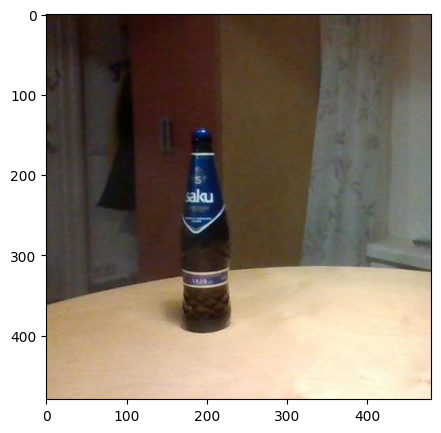

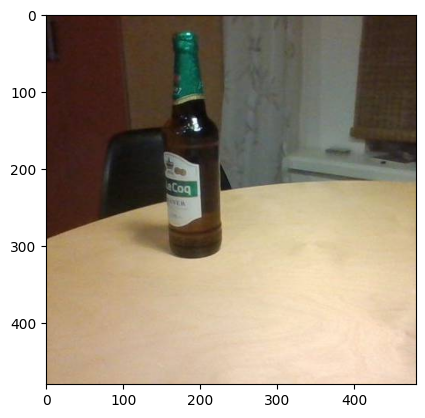

In [13]:
plt.figure(figsize=(10, 5))

#### YOUR CODE STARTS HERE ####
from skimage.io import imread

prev_class1 = imread(f"/content/data/train/{first_class_name}_1.jpg")
prev_class2 = imread(f"/content/data/train/{second_class_name}_1.jpg")

plt.imshow(prev_class1)
plt.show()

plt.imshow(prev_class2)
plt.show()
#### YOUR CODE ENDS HERE ####



## Homework exercise 2 (5 points): Prepare the data for training

<font color='red'>**(Homework exercise 2- a)** In this exercise, we will implement a custom dataset class to handle the data you just gathered. (4 points)</font>



In [14]:
import torch
import torch.nn as nn # all the relevant building blocks
import torch.nn.functional as F # functional interfaces for many operations
from torch.utils.data import Dataset, DataLoader # abstract primitives for handling data in pytorch
from torchvision import transforms
from PIL import Image

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


<font color='red'>Most of the dataset logic has already been written for you, you need only to read the images, get their labels and initialize necessary image transformations. In transformations block, you should resize images to 224 x 224. This is the default image size used by models trained on ImageNet.</font>


In [15]:
class CustomDataset(Dataset):
    def __init__(self, images_dir, augment=True):
        """
        Args:
            images_dir (string): Path to the directory with all the images.
            augment (bool, optional): Whether to augment the images produced by the dataset.
        """
        #### YOUR CODE STARTS HERE ####
        self.images_dir = images_dir
        self.augment = augment
        self.labels = []
        self.images = []

        for filename in os.listdir(images_dir):
            image_path = os.path.join(images_dir, filename)
            image = Image.open(image_path)

            if first_class_name in filename and filename.endswith('.jpg'):
                self.labels.append(0)
                self.images.append(image)
            elif second_class_name in filename and filename.endswith('.jpg'):
                self.labels.append(1)
                self.images.append(image)

        if augment:
            self.transform = transforms.Compose([
                transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.75, 1.33)),
                transforms.ToTensor()
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

        #### YOUR CODE ENDS HERE ####

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = self.transform(image)
        return image, label


<font color='red'>Now we will initialize two instances of dataset class - for training and validation sets.</font>

In [16]:
train_dataset = CustomDataset(images_dir="data/train", augment=True)
val_dataset = CustomDataset(images_dir="data/val", augment=False)

<font color='red'>Wrap the Dataloader class around datasets and decide on the batch size.</font>

In [17]:
#### YOUR CODE STARTS HERE ####
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
#### YOUR CODE ENDS HERE ####

<font color='red'>**(Homework exercise 2- b)** Plot a batch of images produced by the Dataloader. Again, make sure that all of them look okay and nothing weird has happened to them. (1 point) </font>

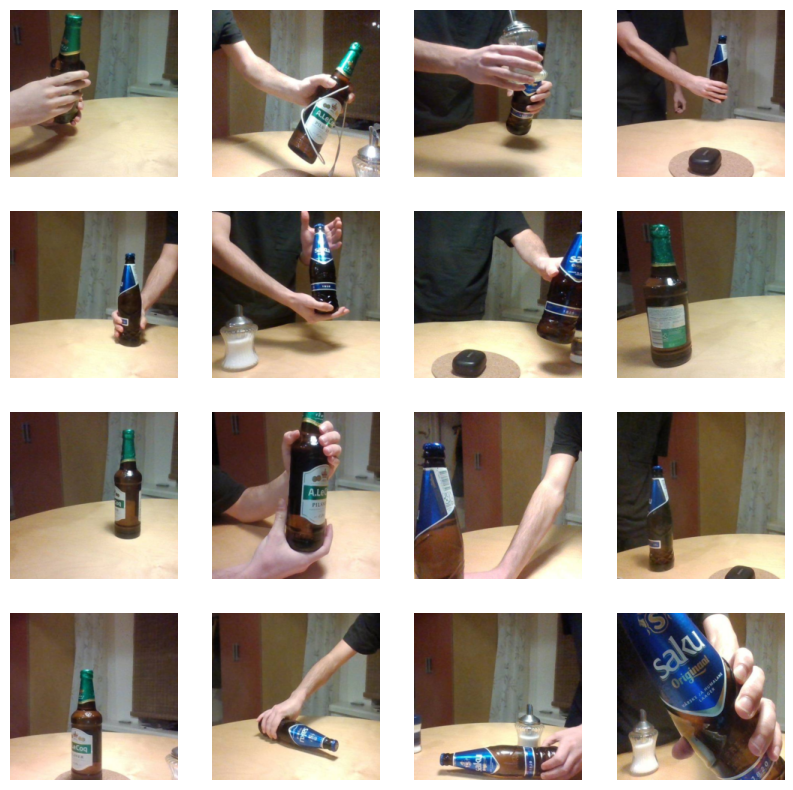

In [18]:
plt.rcParams['figure.figsize'] = (10.0, 10.0) # set default size of plots
#### YOUR CODE STARTS HERE ####
for images_batch,labels_batch in train_loader:
    # Plot each image in the batch
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)  # Adjust subplot grid based on batch size
        plt.imshow(images_batch[i].numpy().transpose(1, 2, 0))
        plt.axis('off')
    plt.show()
    break
#### YOUR CODE ENDS HERE ####

## Homework exercise 3 (4 points): Train and evaluate a simple model on the dataset you prepared earlier.
<font color='red'> In this exercise we will build a simple CNN model using PyTorch as well as develop scripts needed to train and evaluate it. </font>

<font color='red'>**(Homework exercise 3- a)** Implement a simple CNN model, similar to the one we have in the practice session, except that you should have final feature maps of size *8 x 110 x 110* (3 points) </font>

In [19]:
K = 2 # how many classes there are
num_kernels = 8 # number of kernels
image_height = 224
image_width = 224
#OUT = ((IN - 2*Padding - kernel_size ) // stride) + 1
#110 = ((224 - 2*0 - 115) // 1) + 1
kernel_size = 115

D = ((image_height - kernel_size + 1)//2) * ((image_width - kernel_size + 1)//2) * num_kernels

class Simple2LayerCNN(nn.Module):
    def __init__(self):
        super(Simple2LayerCNN, self).__init__()

        #### YOUR CODE STARTS HERE ####
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=kernel_size, padding='valid')
        self.batch = nn.BatchNorm2d(num_kernels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        #### YOUR CODE ENDS HERE ####

        # Adjusting the size of the linear layer
        self.fc = nn.Linear(D, K)

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x)
        x = self.batch(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), - 1) # Flatten the tensor before linear layer

        x = self.fc(x) # Linear layer with softmax at the end
        #### YOUR CODE ENDS HERE ####
        return x

<font color='red'> Now you can initialise your model as well as its optimiser and loss function. </font>

In [20]:
simple_model = Simple2LayerCNN()
simple_model = simple_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(simple_model.parameters(), lr=0.01)

<font color='red'>**(Homework exercise 3- b)** Here complete the code of the `fit` function that we shall use to train our models. (1 point)

 Once completed, this function will serve the same purpose as in Keras. We could have used Keras all the way, but we believe that by implementing `fit` by ourselves we gain more power and control over the exact details. </font>

In [21]:
def fit(model, train_loader, val_loader, n_epochs):
  history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

  for epoch in range(n_epochs):
    # initialise loss and acc for logging
    epoch_loss, val_epoch_loss = 0.0, 0.0
    epoch_acc, val_epoch_acc = 0.0, 0.0

    model.train()
    for images, labels in train_loader:
        #### YOUR CODE STARTS HERE ####
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()   # reseting gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        loss.backward()
        optimizer.step()

        #### YOUR CODE ENDS HERE ####
        epoch_loss += loss.item()
        epoch_acc += torch.mean((torch.argmax(outputs.detach().cpu(), dim=1) == labels.cpu()).float())

    model.eval()
    with torch.no_grad():  # since we are not going to do backprop
      for images, labels in val_loader:
          #### YOUR CODE STARTS HERE ####
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          # Forward pass only
          outputs = model(images)
          loss = criterion(outputs, labels)

          #### YOUR CODE ENDS HERE ####

          val_epoch_loss += loss.item()
          val_epoch_acc += torch.mean((torch.argmax(outputs.detach().cpu(), dim=1) == labels.cpu()).float())

    history['loss'].append(epoch_loss/len(train_loader))
    history['accuracy'].append(epoch_acc/len(train_loader))

    history['val_loss'].append(val_epoch_loss/len(val_loader))
    history['val_accuracy'].append(val_epoch_acc/len(val_loader))

    print(f"Epoch {epoch + 1}, Loss: {history['loss'][-1]}, Val loss: {history['val_loss'][-1]}")

  return history

<font color='red'> Below is a function that we can use to visualise the learning progress. </font>

In [22]:
def plot_curves(history):
  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss')

  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy')

<font color='red'> Finally, we can start training the model. Correctly implemented `fit` should take on average a few seconds per epoch. </font>

In [23]:
history = fit(simple_model, train_loader, val_loader, 20)

Epoch 1, Loss: 16.996791750192642, Val loss: 460.6559753417969
Epoch 2, Loss: 18.673769760131837, Val loss: 40.65529155731201
Epoch 3, Loss: 8.166665697097779, Val loss: 23.753574053446453
Epoch 4, Loss: 5.687484806776046, Val loss: 20.23676602045695
Epoch 5, Loss: 4.50708195567131, Val loss: 9.81924652432402
Epoch 6, Loss: 2.4200073425643494, Val loss: 8.361275513966879
Epoch 7, Loss: 0.7368215836439049, Val loss: 6.756776014963786
Epoch 8, Loss: 1.1829869100798873, Val loss: 4.947679281234741
Epoch 9, Loss: 1.2565961896966484, Val loss: 9.514963547388712
Epoch 10, Loss: 0.9059196965195951, Val loss: 2.0559172481298447
Epoch 11, Loss: 1.1467125706374646, Val loss: 3.188215653101603
Epoch 12, Loss: 1.9591544032096864, Val loss: 3.1604537963867188
Epoch 13, Loss: 1.2425101526081561, Val loss: 1.9056396432248828
Epoch 14, Loss: 0.773845798894763, Val loss: 9.916978130543916
Epoch 15, Loss: 0.8086213018745184, Val loss: 3.5868953963120767
Epoch 16, Loss: 0.7565470553931846, Val loss: 4.20

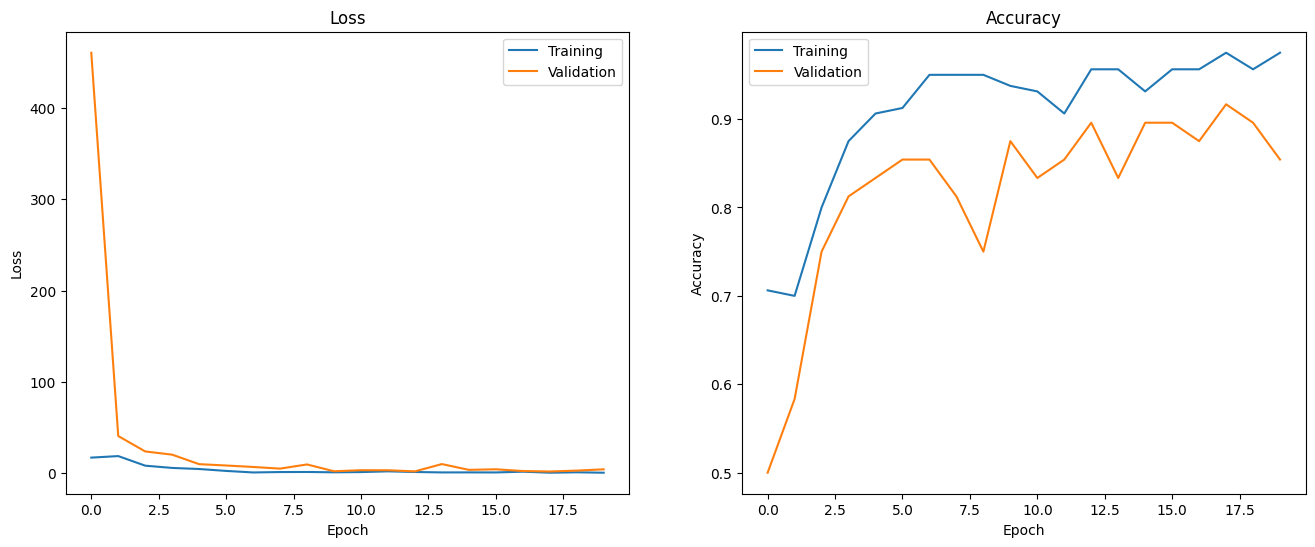

In [24]:

plot_curves(history)

<font color='red'> Let's build a function for evaluating the trained model. </font>

In [25]:
def predict(model, loader):
  model.eval()
  preds = []
  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)
      # Forward pass
      outputs = model(images).detach().cpu().numpy()
      preds.extend(list(np.argmax(outputs, axis=1)))
  return np.array(preds)

<font color='red'> Use `predict` to evaluate your model on the `val_loader`. Report the final accuracy. </font>

In [26]:
preds = predict(simple_model, val_loader)

np.mean(preds == val_dataset.labels)

0.875

## Homework exercise 4 (5 points): Train and evaluate two more CNN models on the same dataset.
<font color='red'> In this exercise, firstly take one existing, pretrained on imagenet model and fine-tune it on your dataset. Then, unleash your creativity and design another model - your unique one. Experiment with trully wild architectural choices and see where it gets you. Compare all model performances. </font>

<font color='red'>**(Homework exercise 4- a)** Check out https://pytorch.org/vision/stable/models.html#classification for a list of existing pretrained models and choose one. Remember that these models were trained for a completely different purpose and using very different dataset. Therefore you will need to adapt this model's last layer to the number of classes in your dataset. Fine-tune it on the training data and evaluate on the validation set. (2 points) </font>

In [27]:
#### YOUR CODE STARTS HERE ####
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)
#### YOUR CODE ENDS HERE ####

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 183MB/s]


<font color='red'> Here, adapt the model to the number of classes in your dataset (if needed).
</font>

In [28]:
#### YOUR CODE STARTS HERE ####
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, K) # K stands for the number of classes
#### YOUR CODE ENDS HERE ####
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<font color='red'> Don't forget to redefine loss function and the optimiser.
</font>

In [29]:
#### YOUR CODE STARTS HERE ####
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#### YOUR CODE ENDS HERE ####

<font color='red'> And now train (or rather fine-tune) the model.
</font>

In [30]:
#### YOUR CODE STARTS HERE ####
history = fit(model, train_loader, val_loader, 20)
#### YOUR CODE ENDS HERE ####

Epoch 1, Loss: 1.1541715562343597, Val loss: 351395.7604166667
Epoch 2, Loss: 0.6586947113275528, Val loss: 4592.705729166667
Epoch 3, Loss: 0.7545840114355087, Val loss: 6.941119750340779
Epoch 4, Loss: 0.6835728168487549, Val loss: 27.55982844034831
Epoch 5, Loss: 0.5355605125427246, Val loss: 0.5452756484349569
Epoch 6, Loss: 0.3537773549556732, Val loss: 0.7058705886205038
Epoch 7, Loss: 0.12945906147360803, Val loss: 0.434403657913208
Epoch 8, Loss: 0.1618905134499073, Val loss: 0.197680682875216
Epoch 9, Loss: 0.33928446769714354, Val loss: 0.2982938587665558
Epoch 10, Loss: 0.20441599003970623, Val loss: 0.16296597570180893
Epoch 11, Loss: 0.06290286310832016, Val loss: 0.01621055050054565
Epoch 12, Loss: 0.060072018577193374, Val loss: 0.028764440988500912
Epoch 13, Loss: 0.19454309849243145, Val loss: 0.6152219474315643
Epoch 14, Loss: 0.25566880628466604, Val loss: 1.5267557899157207
Epoch 15, Loss: 0.25038154423236847, Val loss: 0.06619122251868248
Epoch 16, Loss: 0.20111228

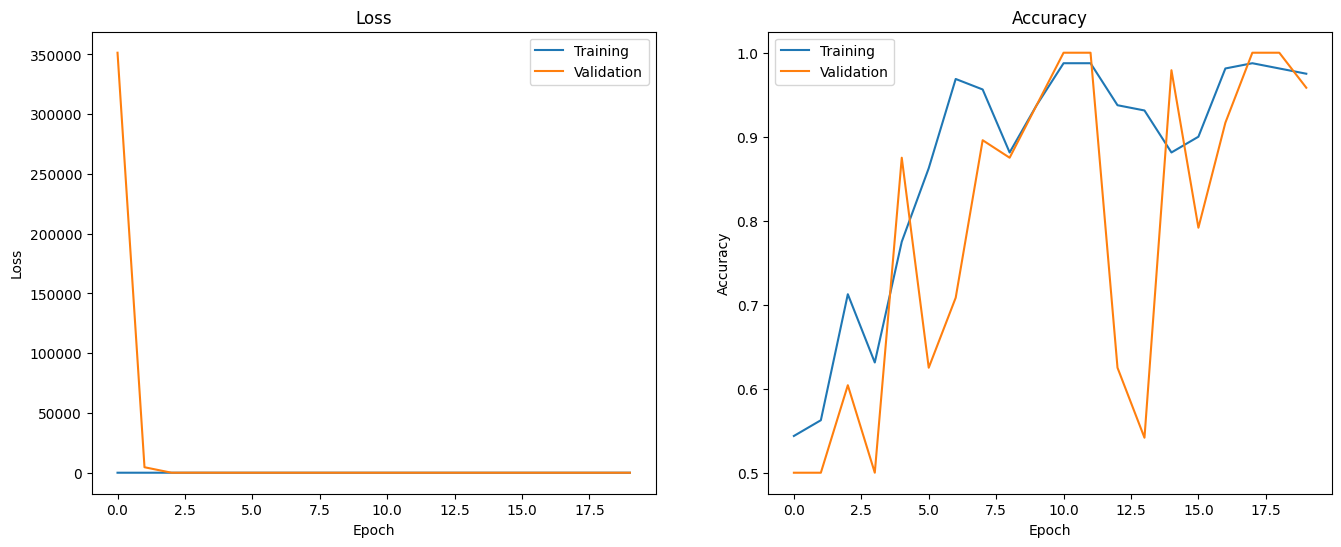

In [31]:
plot_curves(history)

<font color='red'> Evaluate its performance
</font>

In [32]:
preds = predict(model, val_loader)
np.mean(preds == val_dataset.labels)

0.975

<font color='red'>**(Homework exercise 4- b)** Build, train and evaluate your own authentic model. (3 points) </font>

In [33]:
##### My Calculations #########
K = 2 # how many classes there are
num_kernels = 8 # number of kernels
image_height = 224
image_width = 224
#OUT = ((IN - 2*Padding - kernel_size ) // stride) + 1
#211 = ((224 - 2*0 - 12) // 1) + 1
kernel_size = 12 # I tried
##################################

class YourCrazyCoolCNN(nn.Module):
    def __init__(self):
        super(YourCrazyCoolCNN, self).__init__()
        #### YOUR CODE STARTS HERE ####
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=num_kernels, kernel_size=kernel_size, padding='valid')
        self.conv2 = nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels*2, kernel_size=kernel_size, padding='valid')
        self.conv3 = nn.Conv2d(in_channels=num_kernels*2, out_channels=num_kernels*4, kernel_size=kernel_size, padding='valid')
        self.conv4 = nn.Conv2d(in_channels=num_kernels*4, out_channels=num_kernels*8, kernel_size=kernel_size, padding='valid')

        self.batch1 = nn.BatchNorm2d(num_kernels)
        self.batch2 = nn.BatchNorm2d(num_kernels*2)
        self.batch3 = nn.BatchNorm2d(num_kernels*4)
        self.batch4 = nn.BatchNorm2d(num_kernels*8)

        self.relu = nn.ReLU()

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        temp_image_height = 224
        temp_image_height = ((temp_image_height - kernel_size + 1) // 2) #111
        temp_image_height = ((temp_image_height - kernel_size + 1) // 2) #54
        temp_image_height = ((temp_image_height - kernel_size + 1) // 2) #26
        temp_image_height = ((temp_image_height - kernel_size + 1) // 2) #12

        D = temp_image_height * temp_image_height * num_kernels * 8
        self.fc = nn.Linear(D, K)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        #### YOUR CODE STARTS HERE ####
        x = self.conv1(x) # convolutional layer
        x = self.batch1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x) # convolutional layer
        x = self.batch2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x) # convolutional layer
        x = self.batch3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x) # convolutional layer
        x = self.batch4(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = x.view(x.size(0), -1) # Flatten the tensor before linear layer
        x = self.fc(x)
        #### YOUR CODE ENDS HERE ####
        return x

In [34]:
#### YOUR CODE STARTS HERE ####
crazy_model = YourCrazyCoolCNN()
crazy_model = crazy_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(crazy_model.parameters(), lr=0.001)

history = fit(crazy_model, train_loader, val_loader, 20)
#### YOUR CODE ENDS HERE ####

Epoch 1, Loss: 0.601463931798935, Val loss: 0.5499915679295858
Epoch 2, Loss: 0.23065565824508666, Val loss: 0.4316662053267161
Epoch 3, Loss: 0.1910347379744053, Val loss: 0.35551191369692486
Epoch 4, Loss: 0.17651840895414353, Val loss: 0.36797764400641125
Epoch 5, Loss: 0.17929560616612433, Val loss: 0.2724476257960002
Epoch 6, Loss: 0.11981650590896606, Val loss: 0.41417933503786725
Epoch 7, Loss: 0.1719637919217348, Val loss: 0.13802427177627882
Epoch 8, Loss: 0.08543212041258812, Val loss: 0.2755317687988281
Epoch 9, Loss: 0.03105373978614807, Val loss: 0.21980356176694235
Epoch 10, Loss: 0.03978926576673984, Val loss: 0.2309393770992756
Epoch 11, Loss: 0.02407380468212068, Val loss: 0.2507687459389369
Epoch 12, Loss: 0.038576721446588635, Val loss: 0.1402023509144783
Epoch 13, Loss: 0.04054976338520646, Val loss: 0.5192085628708204
Epoch 14, Loss: 0.019382206292357297, Val loss: 0.148141679354012
Epoch 15, Loss: 0.025749822845682502, Val loss: 0.1608894340073069
Epoch 16, Loss: 

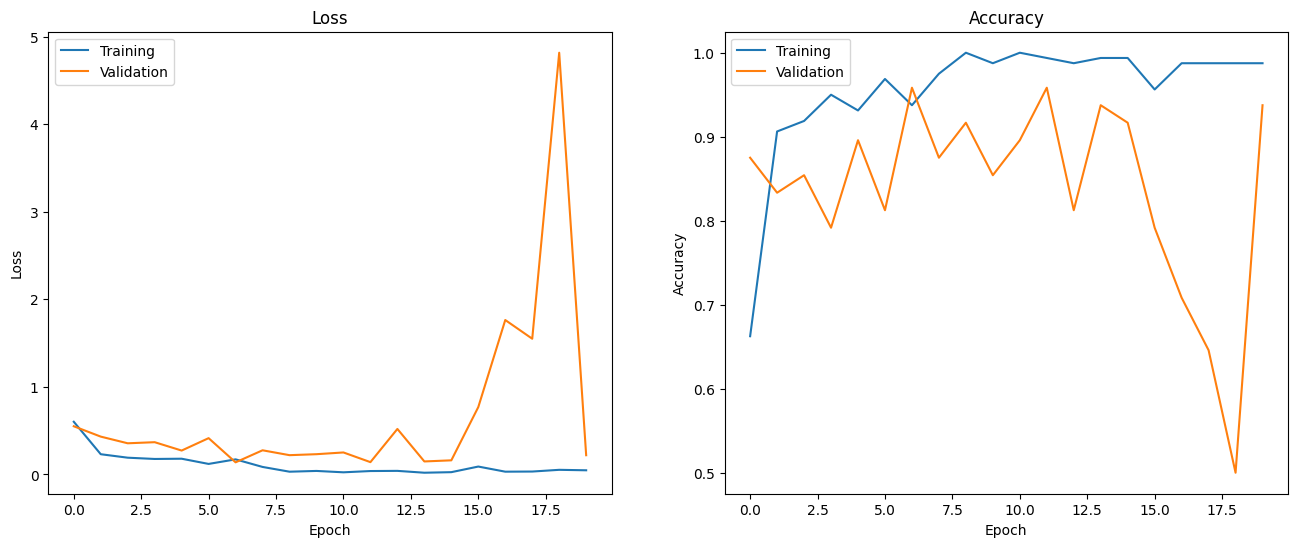

In [35]:
plot_curves(history)

In [36]:
preds = predict(crazy_model, val_loader)
np.mean(preds == val_dataset.labels)

0.925

<font color='red'> Below shortly explain your design and why do you think it should have worked.
</font>

In [37]:
# YOUR SHORT ANSWER: I decided to go for 4 layers to try something stronger. I think the way to learn to differentiate my 2 objects is color based (one is mostly green and the other is blue).
# But results are not that good, sometimes better than the simple, sometimes worse, but not with a big gap

## Homework exercise 5 (3 points): Testing CNNs in the wild.
<font color='red'> **(Homework exercise 5-a)** Collect a new (different) test set (1 point). </font>

<font color='red'> In machine learning we typically refer to data that does not originate from the training data distribution as out-of-distribution (OOD). Usually, models fail miserably when evaluated on OOD data, but it depends on many factors. You should always be on a lookout for this.

Here we ask you to collect an OOD test set and use it to evaluate your models. Make sure to collect images of the same class objects but in significantly different conditions. For example, if you chose to collect a training dataset of cups and wallets using your laptop camera, then here, take a break, go outside and make a few pictures of the cup using your phone on a vastly different background or in various lightning conditions.
</font>

<font color='red'> Your code for uploading a new test set comes here
</font>

In [38]:
#### YOUR CODE STARTS HERE ####

#Please upload "test.zip" here
from google.colab import files
uploaded = files.upload()

!unzip -o test.zip -d data/

#Listing test folder to check names and see how much in
!ls data/test/*.jpg | wc -l
#### YOUR CODE ENDS HERE ####

Saving test.zip to test.zip
Archive:  test.zip
  inflating: data/test/ale_coq_100.jpg  
  inflating: data/test/ale_coq_101.jpg  
  inflating: data/test/ale_coq_102.jpg  
  inflating: data/test/ale_coq_103.jpg  
  inflating: data/test/ale_coq_104.jpg  
  inflating: data/test/ale_coq_105.jpg  
  inflating: data/test/ale_coq_106.jpg  
  inflating: data/test/ale_coq_107.jpg  
  inflating: data/test/ale_coq_108.jpg  
  inflating: data/test/ale_coq_109.jpg  
  inflating: data/test/saku_100.jpg  
  inflating: data/test/saku_101.jpg  
  inflating: data/test/saku_102.jpg  
  inflating: data/test/saku_103.jpg  
  inflating: data/test/saku_104.jpg  
  inflating: data/test/saku_105.jpg  
  inflating: data/test/saku_106.jpg  
  inflating: data/test/saku_107.jpg  
  inflating: data/test/saku_108.jpg  
  inflating: data/test/saku_109.jpg  
20


<font color='red'> **(Homework exercise 5-b)** Evaluate all three models you have trained in the previous exercises on this new test set. Report the resulting accuracies for each (1 point).

In [39]:
#### YOUR CODE STARTS HERE ####

#model1 : simple_model
#model2 : model
#model3 : crazy_model

#Lets make test dataset and then test loader
test_dataset = CustomDataset(images_dir="data/test", augment=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

preds = []
result = []

for temp_model in [simple_model,model,crazy_model]:
    preds.append(predict(temp_model, test_loader))
    result.append( np.mean(preds[-1] == test_dataset.labels) )

print("All models results on new test set\n")
print(f"simple CNN : {result[0]}")
print(f"resnet34   : {result[1]}")
print(f"crazy CNN  : {result[2]}")

#### YOUR CODE ENDS HERE ####

All models results on new test set

simple CNN : 0.5
resnet34   : 0.75
crazy CNN  : 0.45


<font color='red'> **(Homework exercise 5-c)** Discuss the results of the evaluation (1 point):
* <font color='red'> Describe shortly your OOD test set and explain how it is different from the training data.
* <font color='red'> Which model has performed best on the OOD test set? Why do you think this is the case?
</font>

In [40]:
# YOUR SHORT ANSWER: My OOD test set is easier in the way that the objects are always centered and face looking, but the background and the lights are changing
# As you can see, the resnet performed the best by far, I would say this is because of the number of layers.
# After multiples tries, sometimes resnet is not performing that well on here.

## Bonus exercise 1 (2 points): Visualize model's activations
<font color='red'> Here we give you the unique opportunity to take a sneak peak at the internal activations of the model as it tries to classify the images from your dataset.

<font color='red'> We will use the method introduced in the paper [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf).

<font color='red'>The general idea is to attach a so-called deconvnet to the already trained VGG-16 model. Deconvnnet consists of the same number of layers as the convnet, but arranged in the opposite order and performing opposite operations - transposed convolutions instead of usual convolutions and unpooling instead of pooling. Such architecture allows to map the feature maps from feature space back into pixel space. Of course, the mapping isn't perfect as some information is lost after max pooling operations, but it will still allow us to see the most prominent features identified by the model on input image.

<font color='red'> [Here](https://towardsdatascience.com/understand-transposed-convolutions-and-build-your-own-transposed-convolution-layer-from-scratch-4f5d97b2967) you can read more about transposed convolutions.

We prepared most of the code for you, you just need to *understand it* :), fill in some gaps and then visualize the reconstructed features (try it on images from both classes in your dataset). Don't forget to describe your results!</font>

In [ ]:
import torchvision.models as models
import json

In [ ]:
# get the names of ImageNet classes
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

In [ ]:
class Vgg16Conv(nn.Module):
    """
    vgg16 convolution network architecture
    """

    def __init__(self, num_cls=1000):
        """
        Input
            number of classes, default is 1k as in the ImageNet.
        """
        super(Vgg16Conv, self).__init__()

        self.conv_layers = nn.Sequential(
            # conv1
            nn.Conv2d(3, 64, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True), # we need the indices of max values to later undo max pooling

            # conv
            nn.Conv2d(64, 128, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv3
            nn.Conv2d(128, 256, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv4
            nn.Conv2d(256, 512, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),

            # conv5
            nn.Conv2d(512, 512, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_cls),
            nn.Softmax(dim=1)
        )

        # indices of conv layers in Sequential object, which behaves as a list
        self.conv_layer_indices = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]
        # feature maps
        self.feature_maps = {}
        # indices of max values in pooling
        self.pool_locs = {}

        self.init_weights()

    def init_weights(self):
        """
        init weights from pretrained vgg16 model
        """
        vgg16_pretrained = models.vgg16(pretrained=True)

        # init Conv2d
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.conv_layers[idx].weight.data = layer.weight.data
                self.conv_layers[idx].bias.data = layer.bias.data

        # init Linear
        for idx, layer in enumerate(vgg16_pretrained.classifier):
            if isinstance(layer, nn.Linear):
                self.classifier[idx + 1].weight.data = layer.weight.data
                self.classifier[idx + 1].bias.data = layer.bias.data

    def forward(self, x):
        self.feature_maps = {}
        self.pool_locs = {}

        for idx, layer in enumerate(self.conv_layers):
            if isinstance(layer, nn.MaxPool2d):
                x, location = layer(x)
                # save feature maps after every layer and locations of max values after max pooling
                self.feature_maps[idx] = x
                self.pool_locs[idx] = location
            else:
                x = layer(x)
                self.feature_maps[idx] = x

        output = self.classifier(x)
        return output

In [ ]:
class Vgg16Deconv(nn.Module):
    """
    vgg16 transposed convolution network architecture
    """
    def __init__(self):
        super(Vgg16Deconv, self).__init__()

        self.deconv_layers = nn.Sequential(
            # deconv1
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1), # Pay attention to the number of channels in conv transpose layer - it starts from 512 as is in the last layer of VGG16 model
            nn.ReLU(),
            # pytorch supports 'same' and 'valid' keywords for padding in conv layers, but not in transposed conv layers :(
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),

            # deconv2
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 512, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 3, padding=1),

            # deconv3
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 256, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, padding=1),

            # deconv4
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding=1),

            # deconv5
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 3, padding=1)
        )

        # mapping of conv layers to corresponding transposed conv layers
        self.conv2deconv_indices = {
                0:30, 2:28, 5:25, 7:23,
                10:20, 12:18, 14:16, 17:13,
                19:11, 21:9, 24:6, 26:4, 28:2
                }

        self.unpool2pool_indices = {
                26:4, 21:9, 14:16, 7:23, 0:30
                }

        self.init_weight()

    def init_weight(self):
        vgg16_pretrained = models.vgg16(pretrained=True)
        for idx, layer in enumerate(vgg16_pretrained.features):
            if isinstance(layer, nn.Conv2d):
                self.deconv_layers[self.conv2deconv_indices[idx]].weight.data = layer.weight.data
                # Biases are optional, but you can experiment with adding or not adding them
                # self.features[self.conv2deconv_indices[idx]].bias.data = layer.bias.data[:self.features[self.conv2deconv_indices[idx]].bias.shape[0]]

    def forward(self, x, layer, pool_locs):
        if layer in self.conv2deconv_indices:
            start_idx = self.conv2deconv_indices[layer]
        else:
            raise ValueError('layer is not a conv feature map')

        # start deconv from deconv layer which corresponds to conv layer
        # which produced the feature maps and move upwards
        #### YOUR CODE STARTS HERE ####
        ...
        #### YOUR CODE ENDS HERE ####

        return x

In [ ]:
def visualise_layer(layer, conv_model, deconv_model, max_activations_only=True):
    """
    visualing the layer deconv result
    max_activations_only: whether to set all non-max activations to 0
    """
    num_feat = conv_model.feature_maps[layer].shape[1]

    new_feat_map = conv_model.feature_maps[layer].clone().detach() # 1 x num_filters x h x w

    if max_activations_only:

        #### YOUR CODE STARTS HERE ####
        # find index of feature map with max activation value
        ...
        # find max activation value
        ...

        # set all other feature maps to 0
        ...
        ...

        # set all activations < max activation in max feature map to 0
        ...

        #### YOUR CODE ENDS HERE ####


    deconv_output = deconv_model(new_feat_map, layer, conv_model.pool_locs)

    new_img = deconv_output.detach().cpu().numpy()[0].transpose(1, 2, 0)  # h x w x c

    # scale output to be between 0 and 1
    new_img = (new_img - new_img.min()) / (new_img.max() - new_img.min())
    new_img *= 255
    new_img = new_img.astype(np.uint8)

    return new_img

In [ ]:
# Just to make feature maps a bit brighter :)
def make_prettier(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    # set vibrance
    vibrance = 3

    # create 256 element non-linear LUT for sigmoidal function
    # see https://en.wikipedia.org/wiki/Sigmoid_function
    xval = np.arange(0, 256)
    lut = (255*np.tanh(vibrance*xval/255)/np.tanh(1)+0.5).astype(np.uint8)

    # apply lut to saturation channel
    new_s = cv2.LUT(s,lut)

    # combine new_s with original h and v channels
    new_hsv = cv2.merge([h,new_s,v])

    # convert back to RGB
    result =  cv2.cvtColor(new_hsv,  cv2.COLOR_HSV2RGB)
    return result

In [ ]:
def load_images(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

    t_img = transform(img)
    t_img.unsqueeze_(0)
    t_img = t_img.to(device)
    return img, t_img

In [ ]:
# Get the actual ImageNet class label for prediction
def decode_predictions(preds, top=3):
    with open('imagenet_class_index.json') as f:
            class_index_dict = json.load(f)

    results = []
    for pred in preds:
        top_value, top_indices = torch.topk(pred, top)
        result = [[class_index_dict[str(i.item())][1], j.item()] for (i, j) in zip(top_indices, top_value)]
        results.append(result)

    return results

In [ ]:
vgg16_conv = Vgg16Conv()
vgg16_conv.eval()
vgg16_conv.to(device)

vgg16_deconv = Vgg16Deconv()
vgg16_deconv.eval()
vgg16_deconv.to(device)

In [ ]:
img_path = ''
img, in_img = load_images(img_path)

with torch.no_grad():
  out = vgg16_conv(in_img)

print('Predicted:', decode_predictions(out.detach().cpu(), top=3)[0])

In [ ]:
plt.figure(num=None, figsize=(16, 12), dpi=80)
plt.subplot(3, 4, 1)
plt.title('original picture')
plt.imshow(img)

for idx, layer in enumerate(vgg16_conv.conv_layer_indices[1:-1]):
    plt.subplot(3, 4, idx+2)
    out_img = visualise_layer(layer, vgg16_conv, vgg16_deconv, True)
    plt.title(f'conv layer {idx + 2}')
    plt.imshow(make_prettier(out_img))

plt.show()

In [ ]:
# Your interpretation of results goes in here